# Preprocessing tutorial

In this tutorial, we will explore (some of) the possiblities available in SpikeInterface to pimp a bit your data *prior* to sending them to the spike sorting algorithms. Indeed, while some might have some custom/built-in pipelines to preprocess the data, it can not hurt to undersand properly what you are doing, and what should be done. Moreover, quite often the default pipelines are limited, and you might require some more complicated preprocessing steps to enhance the quality of your spike sorting outputs.

First, let's import the module

In [1]:
import spikeinterface.full as si

## Loading the data

In [39]:
from pathlib import Path
recording_raw = si.read_binary_folder('/home/pierre/slice')
print(recording)

HighpassFilterRecording: 151 channels - 30.0kHz - 1 segments - 1,800,000 samples 
                         60.00s (1.00 minutes) - float32 dtype - 1.01 GiB


Let's look at the raw traces, to appreciate what do they look like

In [28]:
%matplotlib widget
si.plot_traces(recording_raw, backend='ipywidgets')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

## Destriping and removing bad channels

Quite often, one need to correct for an aliasing property of the acquisition channels. This is true for Neuropixels, but not only. One can have a look here https://spikeinterface.readthedocs.io/en/latest/how_to/analyse_neuropixels.html for more info. In addition, one can also detect the putative bad channels, and remove them before launching the spike sorters. This will make their lifes easier

In [45]:
# To be done first separate topic 1st
recording_destriped = si.phase_shift(recording_raw, dtype='float32')
si.plot_traces({'destriped' : recording_destriped, 'raw' : recording_raw}, backend='ipywidgets')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [46]:
bad_channel_ids, channel_labels = si.detect_bad_channels(recording_destriped)
recording_destriped = recording_destriped.remove_channels(bad_channel_ids)
print('bad_channel_ids', bad_channel_ids)

bad_channel_ids []


## Filtering the data to get rid of LFP

To get rid of low frequency fluctations (LFP), usually people are performing a high-pass filtering of the data (Kilosort), or a bandpass filter. The cut-off frequencies of these filters are usually set to 150~300 Hz

In [47]:
recording_bandpass = si.bandpass_filter(recording_destriped, freq_min=150, dtype='float32')
recording_highpass = si.highpass_filter(recording_destriped, freq_min=150, dtype='float32')
si.plot_traces({'bandpass' : recording_bandpass, 'highpass' : recording_highpass}, backend='ipywidgets')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

## Referencing the data 

Once the data have been filtered, one must usally remove the common fluctuations that could be due either to artefacts (movements, ...) or to acquisition properties. Several choices can be made. Either the user has a know ground channel that should be used as a reference, and thus removed from all the others. Either the ground is not known, and a common average reference should be made. In this case, either the mean or the median over all channels is subtracted, at every time step. Note that this can have some drawbacks. Can you think of any?

In [48]:
# We decide to go for the highpass filtering
recording_cmr_global = si.common_reference(recording_highpass, reference='global')
recording_cmr_local = si.common_reference(recording_highpass, reference='local', local_radius = (50, 150))
si.plot_traces({'local' : recording_cmr_local, 'global' : recording_cmr_global}, backend='ipywidgets')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

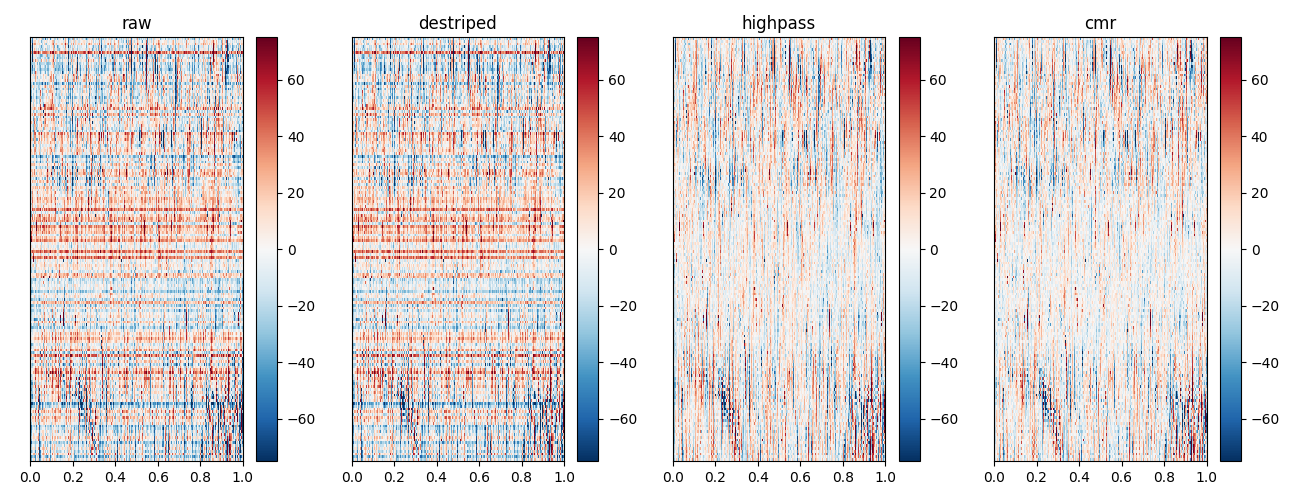

In [50]:
# here we use static plot using matplotlib backend
import pylab as plt
fig, axs = plt.subplots(ncols=4, figsize=(13, 5))
cmin, cmax = -75, 75
si.plot_traces(recording_raw, backend='matplotlib',  clim=(cmin, cmax), ax=axs[0])
si.plot_traces(recording_destriped, backend='matplotlib',  clim=(cmin, cmax), ax=axs[1])
si.plot_traces(recording_highpass, backend='matplotlib',  clim=(cmin, cmax), ax=axs[2])
si.plot_traces(recording_cmr_global, backend='matplotlib',  clim=(cmin, cmax), ax=axs[3])
for i, label in enumerate(('raw', 'destriped', 'highpass', 'cmr')):
    axs[i].set_title(label)
plt.tight_layout()

## Removing artefacts and/or silence entire periods

One might think that this is enough, but not yet! Quite often, you might have periods in your data where you know the signal is crap (because of an unplugged cable, or because mistakes were made). Ideally, you want to remove these periods as much as possible otherwise their statistical properties migh bias the estimations performed by the sorting algorithms. Moreover, it could also be that you have regularly occuring in your data, such as for example an external stimulation, regularly occuring at known times. Ideally, you should get rid of these periods

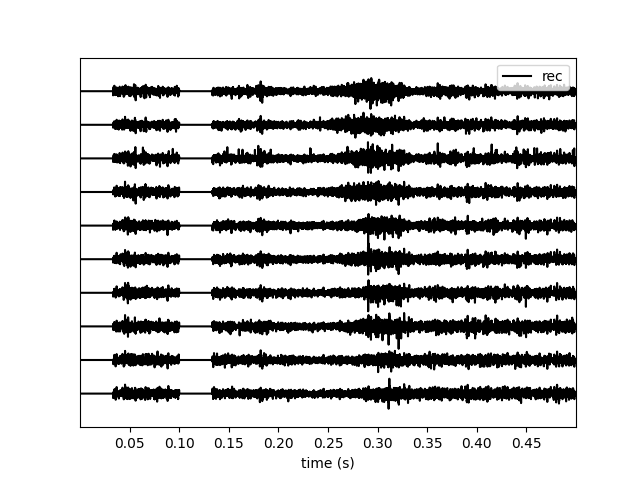

In [51]:
silenced_recording = si.silence_periods(recording_cmr_global, [[0, 1000], [3000, 4000]])
channel_ids = silenced_recording.channel_ids
si.plot_traces(silenced_recording, channel_ids=channel_ids[:10], mode='line', time_range=(0, 0.5))

## Whitening / Normalizing the data

Once your data are filtered, destriped, registered, and free from any artefacts, then you might start to think considering sending them to a spike sorting algorithm. However, there is still an issue if the noise levels, on all the channels, are not the same and/or if you have spurious noise correlations between your recording channals. Therefore, to tackle this issue, a common step in spike sorting is to first "whiten" the data, i.e. to estimate the covariance matrix of the noise between your channels, and get rid of it in your data (via multiplication of the inverted matrix)

In [43]:
whiten_recording = si.whiten(silenced_recording)
zscore_recording = si.zscore(silenced_recording)

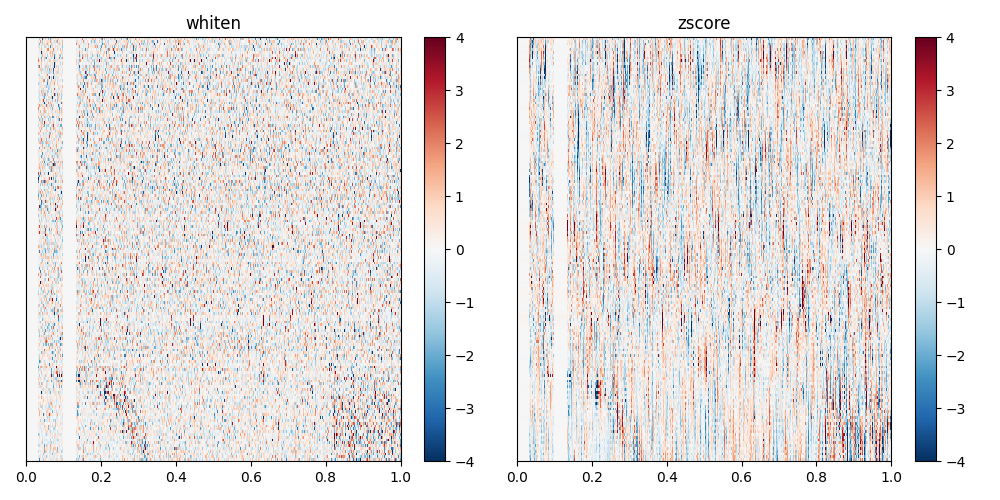

In [52]:
# here we use static plot using matplotlib backend
import pylab as plt
fig, axs = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)
si.plot_traces(whiten_recording, backend='matplotlib', clim=(-4, 4), ax=axs[0])
si.plot_traces(zscore_recording, backend='matplotlib', clim=(-4, 4), ax=axs[1])
for i, label in enumerate(('whiten', 'zscore')):
    axs[i].set_title(label)
plt.tight_layout()

## And much more

To see the full list of all the possibilities offered by SpikeInterface to preprocess your recording, you can do

In [37]:
si.preprocessers_full_list

[spikeinterface.preprocessing.filter.FilterRecording,
 spikeinterface.preprocessing.filter.BandpassFilterRecording,
 spikeinterface.preprocessing.filter.HighpassFilterRecording,
 spikeinterface.preprocessing.filter.NotchFilterRecording,
 spikeinterface.preprocessing.filter_gaussian.GaussianBandpassFilterRecording,
 spikeinterface.preprocessing.normalize_scale.NormalizeByQuantileRecording,
 spikeinterface.preprocessing.normalize_scale.ScaleRecording,
 spikeinterface.preprocessing.normalize_scale.CenterRecording,
 spikeinterface.preprocessing.normalize_scale.ZScoreRecording,
 spikeinterface.preprocessing.whiten.WhitenRecording,
 spikeinterface.preprocessing.common_reference.CommonReferenceRecording,
 spikeinterface.preprocessing.phase_shift.PhaseShiftRecording,
 spikeinterface.preprocessing.rectify.RectifyRecording,
 spikeinterface.preprocessing.clip.ClipRecording,
 spikeinterface.preprocessing.clip.BlankSaturationRecording,
 spikeinterface.preprocessing.silence_periods.SilencedPeriodsRe